<a href="https://colab.research.google.com/github/dbetm/DeepLearningLifeSciences/blob/main/11_virtual_screening/2_Predict_ability_inhibition_ERK2_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem:** Predict the ability of molecules to inhibit a protein known as ERK2 (Mitogen Activated Protein Kinase 1, MAPK1).

ERK2 plays an important role in the signaling pathways that regulate how cells multiply. ERK2 has been implicated in a number of cancers. It's important to know some inhibitors for some types of cancer.

**Solution:** We will train the model to distinguish a set of ERK2 active compounds from a set of decoy compounds.

*What is decoy compounds?*

Decoys are molecules that are presumed to be inactive against a target (i.e. will not likely bind to the target) and are used to validate the performance of molecular docking or a virtual screening workflow.

**Database: **The active and decoy compounds are derived from the [DUD-E database](http://dud.docking.org/).

- A total of 2,950 active compounds against a total of 40 targets.
- For each active, 36 "decoys" with similar physical properties (e.g. molecular weight, calculated LogP) but dissimilar topology.

## Setup

In [1]:
!pip install --pre deepchem
import deepchem as dc
dc.__version__

     |████████████████████████████████| 605 kB 5.1 MB/s 


'2.6.0.dev'

In [2]:
# RDKIT libraries for chemistry functions
!pip install rdkit-pypi

     |████████████████████████████████| 19.7 MB 31.2 MB/s 


In [3]:
import sys

from deepchem.models import GraphConvModel
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
import seaborn as sns

In [4]:
!mkdir 'models'

## Loading dataset

In [ ]:
from google.colab import files

# please select the generated dataset (csv file) - dude_erk1_mk01.csv
files.upload() 

**Note:** If you don't have the generated dataset _dude_erk1_mk01.csv_, you can download it from [here](https://github.com/dbetm/DeepLearningLifeSciences/blob/main/11_virtual_screening/dude_erk1_mk01.csv)



In [7]:
dataset_file = 'dude_erk1_mk01.csv'
tasks = ['is_active']
featurizer = dc.feat.ConvMolFeaturizer()

loader = dc.data.CSVLoader(tasks=tasks, feature_field='SMILES', featurizer=featurizer)

dataset = loader.create_dataset(inputs=dataset_file, shard_size=8192)

## Creating and training the model

In [8]:
def generate_graph_conv_model():
  batch_size = 128
  model = GraphConvModel(
    n_tasks=1, 
    batch_size=batch_size,
    mode='classification',
    model_dir='models/'
  )

  return model

In [9]:
# Split the dataset into training, validation and testing sets
splitter = dc.splits.RandomSplitter()

Our dataset is unbalanced (we have a small number of active compounds and a large number of inactive compounds). 

One metric for unbalanced datasets is **Matthews correlation coefficient (MCC)**.

In [10]:
metrics = dc.metrics.Metric(
  metric=dc.metrics.matthews_corrcoef, 
  task_averager=np.mean, 
  mode='classification'
)

### Training

We will permorm 10 folds of [cross validation](https://docs.aws.amazon.com/machine-learning/latest/dg/cross-validation.html).

In [11]:
cv_folds = 10

In [ ]:
training_scores = []
validation_scores = []
transformers = []

for _ in range(0, cv_folds):
  model = generate_graph_conv_model()

  res = splitter.train_valid_test_split(dataset)
  train_set, valid_set, test_set = res

  model.fit(train_set)

  # evaluation
  training_scores.append(
    model.evaluate(train_set, metrics, transformers)['mean-matthews_corrcoef']
  )
  validation_scores.append(
    model.evaluate(valid_set, metrics, transformers)['mean-matthews_corrcoef']
  )


In [13]:
print(training_scores)
print(validation_scores)

[0.6925715669297021, 0.7037250937927308, 0.8874180607161601, 0.663484468704159, 0.8549621258262696, 0.8403915647601724, 0.8666055955704699, 0.9055953801867718, 0.8143774003802622, 0.6402881974762532]
[0.4433162349439269, 0.6518011356977635, 0.4983739794337415, 0.7344976320140556, 0.7040189638958985, 1.0, 0.8499867778251156, 0.562199358128814, 0.6630256418076944, 0.7032364358565029]


In [14]:
print("Average score using training dataset: ", np.array(training_scores).mean())
print("Average score using validation dataset: ", np.array(validation_scores).mean())

Average score using training dataset:  0.7869419454342952
Average score using validation dataset:  0.6810456159603513


A bit of overfitting

### Visualization the performance of the model on the training and test data using a [boxplots](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

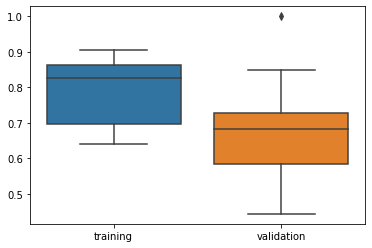

In [15]:
sns.boxplot(
  x=['training'] * cv_folds + ['validation'] * cv_folds,
  y=training_scores + validation_scores
)

## Testing

In [17]:
_, valid_set, test_set = splitter.train_valid_test_split(dataset)

predictions = [x.flatten() for x in model.predict(test_set)]
predictions = pd.DataFrame(predictions, columns=['neg', 'pos'])

In [18]:
# add the activity class (1 = active, 0 = inactive) and the SMILES strings
predictions['active'] = [int(x) for x in test_set.y]
predictions['SMILES'] = test_set.ids
predictions.head()

,neg,pos,active,SMILES
0,0.999848,0.000152,0,COc1c(cc(cc1Cl)Cl)C(=O)NC(=S)Nc2c(c3c(s2)CCCC3...
1,0.998840,0.001160,0,c1cc(c(cc1N)C(=O)N)N2CCN(CC2)CC(F)(F)F
2,0.999242,0.000758,0,Cc1cc(n(n1)c2c(c(ncn2)Nc3ccc(cc3)Br)N)C
3,0.999494,0.000506,0,Cn1c(c(c(=O)[nH]c1=O)N2CCC[C@H](C2)CO)N
4,0.999982,0.000018,0,C/C=C(/C)\C(=O)O[C@@H]1[C@@H]([C@@H]([C@@H](O[...


How good are the predictions? 

We can use a Boxplot to look at the distribution of values for both classes (1 = active, 0 = inactive).

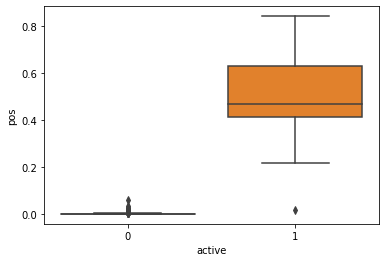

In [19]:
sns.boxplot(x=predictions.active, y=predictions.pos)

### False negative

When building a predictive model it is often important to examine inactive molecules that are predicted as active (**false positives**) as well as active molecules that are predicted as inactive (**false negatives**).

,neg,pos,active,SMILES,Mol
9,0.784932,0.215068,1,CNC(=O)Nc1ccc(cn1)CNc2c(cnn2C)C(=O)Nc3ccc(cc3)...,
56,0.981178,0.018822,1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,
186,0.530697,0.469303,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3ccccc3)...,
279,0.550919,0.449081,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NCCc4...,
361,0.538143,0.461857,1,c1ccc(cc1)CNC(=O)c2cc(c[nH]2)c3c(cn[nH]3)c4ccc...,
436,0.626198,0.373802,1,CCCCNC(=O)N1Cc2c(n[nH]c2NC(=O)[C@@H](C)c3ccc4c...,

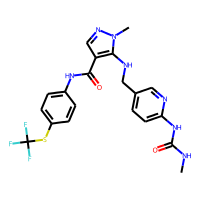
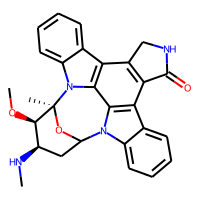
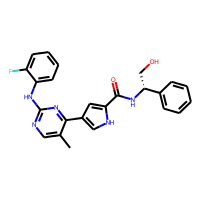
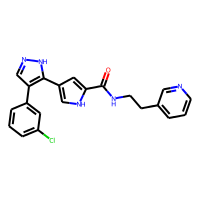
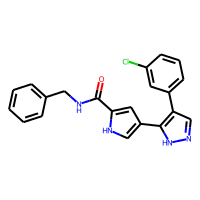
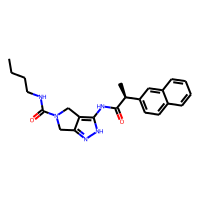

In [20]:
false_negative_ones = predictions.query('active == 1 & pos < 0.5').copy()
# add visual chemical structures
PandasTools.AddMoleculeColumnToFrame(false_negative_ones, 'SMILES', 'Mol')
false_negative_ones

It is often informative to look at the chemical structures of the false negative molecules and compare these with the chemical structures of the true positive molecules. This may provide some insight into the reasons that molecules were not predicted correctly.

## False positive

Molecules which are inactive but received a positive score > 0.5

In [21]:
false_positive_ones = predictions.query('active == 0 & pos >= 0.5').copy()
# add visual chemical structures
PandasTools.AddMoleculeColumnToFrame(false_positive_ones, 'SMILES', 'Mol')
false_positive_ones

,neg,pos,active,SMILES,Mol


## Generating the final model
Note: The method to save the model is not implemented yet for 2.6.0.dev version of DeepChem.

In [ ]:
model = generate_graph_conv_model()
# Training using the full dataset (10 epochs)
model.fit(dataset=dataset, nb_epoch=10)

In [23]:
# evaluating performance
final_coef = model.evaluate(dataset, metrics, transformers)
final_coef

{'mean-matthews_corrcoef': 0.9127227719188966}

## Saving model checkpoint on Google Drive

In [26]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Copying model folder to my Google Drive

In [27]:
# copying model folder to my Google Drive
!mkdir 'gdrive/MyDrive/DLLifeSciences'

In [28]:
!cp -R models/ 'gdrive/MyDrive/DLLifeSciences'

In [25]:
# We can use the saved model later with the restore() method
# model.restore() # not implemente method